# Experimental Implementation of DP-WGAN<br/>Differentially Private Synthetic Data Generation 
- for **Continuous Data with binary Targets** using DP-WGAN (Differentially Private Wasserstein GAN)
- Dataset used in this notebook: "[Health care: Heart attack possibility](https://www.kaggle.com/datasets/nareshbhat/health-care-data-set-on-heart-attack-possibility?select=heart.csv)" 
[Kaggle Dataset]
---

### Code Ownership: Source of Content 
The following notebook has been built to provide an overview of a data pipeline setups for <strong>generating differentially private synthetic data</strong>. [DP-SDG].<br/> Major parts of this summary notebook were extracted from this [BOREALIS Private Data Generation](https://github.com/BorealisAI/private-data-generation) Github repository by BorealisAI. Note that, this Jupyter notebook covers only one (DP-WGAN) of various possible datasets and generative models for differentially private synthetic data generation.


###  Process Steps & Key Concepts
- The data needs to be in csv format and has to be partitioned as train and test before feeding it to the models. 
- Missing values are not supported and needs to replaced appropriately by the user before usage.
- In case the data has continuous and categorical attributes, it needs to be pre-processed <br/>(discretization for continuous values/ encoding for categorical attr.)<br/><br/>
- The generative GAN-based ML models are trained using the training dataset. 
- The generative model is used to create a synthetic version of the train dataset
- To compensate for irregularities multiple GAN-Generator models are trained
- To compensate for irregularities multiple synthetic datasets are generated,<br/> the optimal best-performing dataset that yields the max AUC is selected<br/><br/>
- **Logistic Regression Classifiers** are trained using the real training data and on the synthetically generated training data 
- Both classifiers are evaluated regarding performance on the left-out test dataset (real test data, preserved for evaluation)

---

### DP-SDG Glossary

The aforementioned analysis aproaches have yielded the following results as extracted from the original notebook:<r/><br/>
For more information rearding differential privacy specific privacy arguments (Delta/Eps etc) please refer to:<br/> https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/dwork.pdf


- <strong>Epsilon/Delta: </strong>epsilon and delta parameters of differential privacy
- <strong>Sigma</strong>: Gaussian noise variance multiplier. A larger sigma will make the model train for longer epochs for the same privacy budget 

---

## INSTALL REQUIREMENTS

In [1]:
# IMPORT Generals 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import six
import sys
import math
import argparse
import collections
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import special
from scipy.special import expit

In [2]:
# ScikitLearn Imports
from sklearn import metrics
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
# Change environment for PyTorch
os.environ["CUDA_VISIBLE_DEVICES"]=""
# PyTorch Imports
!{sys.executable} -m pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
device = torch.device("cpu")

## Fundamental Data Analytics - Validation - Visualization


In [4]:
def traindata_analytics(df_source):
    
    # store column names from the input dataset 
    data_cols = list(df_source.columns.values) 
    
    list_min = df_source.min().to_list()
    list_max = df_source.max().to_list()
    list_mean = df_source.mean().to_list()
    list_var = df_source.var().to_list()
    list_mean = [round(num, 4) for num in list_mean]

    # aggregate information within one single dataframe 
    joint_df = pd.DataFrame(list(zip(data_cols, list_mean, list_var, list_min, list_max)),
                            columns =['attribute name', 'mean', 'var', 'min', 'max'])

    print('\n', df_source.hist(bins=100, figsize=(15, 10), color='#86BC25'))
    display(joint_df)

In [5]:
def traindata_analytics_comparison(df_source_orig, df_source_synth):
    
    # store column names from the input dataset 
    data_cols = list(df_source_orig.columns.values) 
    
    orig_min = df_source_orig.min().to_list()
    orig_max = df_source_orig.max().to_list()
    orig_var = df_source_orig.var().to_list()
    orig_mean = df_source_orig.mean().to_list()
    orig_mean = [round(num, 4) for num in orig_mean]
    
    synth_min = df_source_synth.min().to_list()
    synth_max = df_source_synth.max().to_list()
    synth_var = df_source_synth.var().to_list()
    synth_mean = df_source_synth.mean().to_list()
    synth_mean = [round(num, 4) for num in synth_mean]
    
    # aggregate information within one single dataframe 
    joint_df_orig = pd.DataFrame(list(zip(data_cols, orig_mean, orig_var, orig_min, orig_max)),
                                 columns =['attribute_name', 'orig_mean', 'orig_var', 'orig_min', 'orig_max'])
    # aggregate information within one single dataframe 
    joint_df_synth = pd.DataFrame(list(zip(synth_mean, synth_var, synth_min, synth_max)),
                                 columns =['synth_mean', 'synth_var', 'synth_min', 'synth_max'])
    joint_df = pd.concat([joint_df_orig, joint_df_synth], axis=1) 
    display(joint_df) # display stats comparison 
    

    for col in data_cols:
        # DISPLAY COMPARISON PLOT ROC Curves
        fig, ax1 = plt.subplots(figsize=(10,7.5))

        range_orig = (df_source_orig[col].max() - df_source_orig[col].min())
        range_synth = (df_source_synth[col].max() - df_source_synth[col].min())
        max_bins = 100
        
        if range_orig >= range_synth:
            bins_orig = max_bins
            bins_synth = round(max_bins*range_synth/range_orig)
        if range_orig < range_synth:
            bins_synth = max_bins
            bins_orig = round(max_bins*range_orig/range_synth)
    
        ax1.hist(df_source_orig[col], color='darkslategrey', bins=bins_orig, label='orig data')
        ax1.hist(df_source_synth[col], color='#86BC25', bins=bins_synth, label='synth data')
        ax1.legend(prop={'size': 16})
        ax1.set_title(col, fontdict={'fontsize': 14, 'fontweight': 'medium'})
        
        plt.tight_layout()
        plt.show() 
    
    # print('\n', df_source_orig.hist(bins=75, figsize=(15, 10), color='darkslategrey'))
    # print('\n', df_source_synth.hist(bins=75, figsize=(15, 10), color='#86BC25'))

In [6]:
def corrmatrix_comparision(df_source_orig, df_source_synth, title_left, title_right):
    
    fig = plt.figure(figsize=[12,6], dpi=400)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.set_title(title_left)
    ax2.set_title(title_right)
    
    corr_orig = df_source_orig.corr()
    sns.heatmap(corr_orig, mask=np.zeros_like(corr_orig, dtype=np.bool),
                cmap=sns.light_palette("darkslategrey", as_cmap=True),
                square=True, ax=ax1)
    
    corr_synth = df_source_synth.corr()
    sns.heatmap(corr_synth, mask=np.zeros_like(corr_synth, dtype=np.bool),
                cmap=sns.light_palette("darkslategrey", as_cmap=True),
                square=True, ax=ax2)
    
    plt.tight_layout()
    plt.show() 

In [7]:
def supervised_model_training(x_train, y_train, x_test, y_test, data_name, log_result):
    
    # Train LogsticRegression model and report the results.
    model = LogisticRegression(random_state=42)
    model.fit(x_train, y_train)
    y_predict = model.predict_proba(x_test)[:,1]
    y_predict_binary = np.round(y_predict)
    
    # PLOT ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)

    # AUC / AUPRC Computation
    auc = round(metrics.roc_auc_score(y_test, y_predict), 4)
    apr = round(metrics.average_precision_score(y_test, y_predict), 4)
    acc = round(metrics.accuracy_score(y_test, y_predict_binary), 4) 
    if log_result:
        print(f'LogReg Performance for Dataset: \"{data_name.ljust(20)}\" - AUC: {auc}, Accuracy: {acc}')
    return fpr, tpr, auc, apr, acc

## Setup Model Pipeline - DP-WGAN Wasserstein

<strong> Differentially Private Synthetic Data Generation</strong>
- Train/Test Split 75/25 - Evaluated via sklearn LogisticRegression <strong>[BOREALIS DP-WGAN Model repository](https://github.com/BorealisAI/private-data-generation)</strong><br/>

In [8]:
# UTILS - HELPER 

def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

        
def pate(data, netTD, lap_scale):
    results = torch.Tensor(len(netTD), data.size()[0]).type(torch.int64)
    for i in range(len(netTD)):
        output = netTD[i].forward(data)
        pred = (output > 0.5).type(torch.Tensor).squeeze()
        results[i] = pred

    clean_votes = torch.sum(results, dim=0).unsqueeze(1).type(torch.DoubleTensor)
    noise = torch.from_numpy(np.random.laplace(loc=0, scale=1/lap_scale, size=clean_votes.size()))
    noisy_results = clean_votes + noise
    noisy_labels = (noisy_results > len(netTD)/2).type(torch.DoubleTensor)

    return noisy_labels, clean_votes


def moments_acc(num_teachers, clean_votes, lap_scale, l_list):
    q = (2 + lap_scale * torch.abs(2*clean_votes - num_teachers)
         )/(4 * torch.exp(lap_scale * torch.abs(2*clean_votes - num_teachers)))

    update = []
    for l in l_list:
        a = 2*lap_scale*lap_scale*l*(l + 1)
        t_one = (1 - q) * torch.pow((1 - q) / (1 - math.exp(2*lap_scale) * q), l)
        t_two = q * torch.exp(2*lap_scale * l)
        t = t_one + t_two
        update.append(torch.clamp(t, max=a).sum())

    return torch.DoubleTensor(update)


def mutual_information(labels_x: pd.Series, labels_y: pd.DataFrame):

    if labels_y.shape[1] == 1:
        labels_y = labels_y.iloc[:, 0]
    else:
        labels_y = labels_y.apply(lambda x: ' '.join(x.get_values()), axis=1)

    return mutual_info_score(labels_x, labels_y)


def normalize_given_distribution(frequencies):
    distribution = np.array(frequencies, dtype=float)
    distribution = distribution.clip(0)  # replace negative values with 0
    summation = distribution.sum()
    if summation > 0:
        if np.isinf(summation):
            return normalize_given_distribution(np.isinf(distribution))
        else:
            return distribution / summation
    else:
        return np.full_like(distribution, 1 / distribution.size)

In [9]:
# UTILS - ARCHITECTURES

class Generator(nn.Module):
    def __init__(self, latent_size, output_size, conditional=True):
        super().__init__()
        z = latent_size
        d = output_size
        if conditional:
            z = z + 1
        else:
            d = d + 1
        self.main = nn.Sequential(
            nn.Linear(z, 2 * latent_size),
            nn.ReLU(),
            nn.Linear(2 * latent_size, d))

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, input_size, wasserstein=False):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size + 1, int(input_size / 2)),
            nn.ReLU(),
            nn.Linear(int(input_size / 2), 1))

        if not wasserstein:
            self.main.add_module(str(3), nn.Sigmoid())

    def forward(self, x):
        return self.main(x)

In [10]:
# UTILS - IMPORTS FROM rdp_accountant.py

def _log_add(logx, logy):
    """Add two numbers in the log space."""
    a, b = min(logx, logy), max(logx, logy)
    if a == -np.inf:  # adding 0
        return b
    # Use exp(a) + exp(b) = (exp(a - b) + 1) * exp(b)
    return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


def _log_sub(logx, logy):
    """Subtract two numbers in the log space. Answer must be non-negative."""
    if logx < logy:
        raise ValueError("The result of subtraction must be non-negative.")
    if logy == -np.inf:  # subtracting 0
        return logx
    if logx == logy:
        return -np.inf  # 0 is represented as -np.inf in the log space.

    try:
        #Use exp(x) - exp(y) = (exp(x - y) - 1) * exp(y).
        return math.log(math.expm1(logx - logy)) + logy  # expm1(x) = exp(x) - 1
    except OverflowError:
        return logx


def _log_print(logx):
    """Pretty print."""
    if logx < math.log(sys.float_info.max):
        return "{}".format(math.exp(logx))
    else:
        return "exp({})".format(logx)


def _compute_log_a_int(q, sigma, alpha):
    """Compute log(A_alpha) for integer alpha. 0 < q < 1."""
    assert isinstance(alpha, six.integer_types)

    # Initialize with 0 in the log space.
    log_a = -np.inf

    for i in range(alpha + 1):
        log_coef_i = (math.log(special.binom(alpha, i)) + i * math.log(q) + (alpha - i) * math.log(1 - q))

        s = log_coef_i + (i * i - i) / (2 * (sigma**2))
        log_a = _log_add(log_a, s)

    return float(log_a)


def _compute_log_a_frac(q, sigma, alpha):
    """Compute log(A_alpha) for fractional alpha. 0 < q < 1."""
    # The two parts of A_alpha, integrals over (-inf,z0] and [z0, +inf), are
    # initialized to 0 in the log space:
    log_a0, log_a1 = -np.inf, -np.inf
    i = 0

    z0 = sigma**2 * math.log(1 / q - 1) + .5

    while True:  # do ... until loop
        coef = special.binom(alpha, i)
        log_coef = math.log(abs(coef))
        j = alpha - i

        log_t0 = log_coef + i * math.log(q) + j * math.log(1 - q)
        log_t1 = log_coef + j * math.log(q) + i * math.log(1 - q)

        log_e0 = math.log(.5) + _log_erfc((i - z0) / (math.sqrt(2) * sigma))
        log_e1 = math.log(.5) + _log_erfc((z0 - j) / (math.sqrt(2) * sigma))

        log_s0 = log_t0 + (i * i - i) / (2 * (sigma**2)) + log_e0
        log_s1 = log_t1 + (j * j - j) / (2 * (sigma**2)) + log_e1

        if coef > 0:
              log_a0 = _log_add(log_a0, log_s0)
              log_a1 = _log_add(log_a1, log_s1)
        else:
              log_a0 = _log_sub(log_a0, log_s0)
              log_a1 = _log_sub(log_a1, log_s1)

        i += 1
        if max(log_s0, log_s1) < -30:
              break

    return _log_add(log_a0, log_a1)


def _compute_log_a(q, sigma, alpha):
    """Compute log(A_alpha) for any positive finite alpha."""
    if float(alpha).is_integer():
        return _compute_log_a_int(q, sigma, int(alpha))
    else:
        return _compute_log_a_frac(q, sigma, alpha)


def _log_erfc(x):
    """Compute log(erfc(x)) with high accuracy for large x."""
    try:
        return math.log(2) + special.log_ndtr(-x * 2**.5)
    except NameError:
        # If log_ndtr is not available, approximate as follows:
        r = special.erfc(x)
        if r == 0.0:
          # Using the Laurent series at infinity for the tail of the erfc function:
          #     erfc(x) ~ exp(-x^2-.5/x^2+.625/x^4)/(x*pi^.5)
          # To verify in Mathematica:
          #     Series[Log[Erfc[x]] + Log[x] + Log[Pi]/2 + x^2, {x, Infinity, 6}]
              return (-math.log(math.pi) / 2 - math.log(x) - x**2 - .5 * x**-2 + .625 * x**-4 - 37. / 24. * x**-6 + 353. / 64. * x**-8)
        else:
              return math.log(r)


def _compute_delta(orders, rdp, eps):
    """Compute delta given a list of RDP values and target epsilon.
    Args:
    orders: An array (or a scalar) of orders.
    rdp: A list (or a scalar) of RDP guarantees.
    eps: The target epsilon.
    Returns:
    Pair of (delta, optimal_order).
    Raises:
    ValueError: If input is malformed.
    """
    orders_vec = np.atleast_1d(orders)
    rdp_vec = np.atleast_1d(rdp)

    if len(orders_vec) != len(rdp_vec):
        raise ValueError("Input lists must have the same length.")

    deltas = np.exp((rdp_vec - eps) * (orders_vec - 1))
    idx_opt = np.argmin(deltas)
    return min(deltas[idx_opt], 1.), orders_vec[idx_opt]


def _compute_eps(orders, rdp, delta):
    """Compute epsilon given a list of RDP values and target delta.
    Args:
    orders: An array (or a scalar) of orders.
    rdp: A list (or a scalar) of RDP guarantees.
    delta: The target delta.
    Returns:
    Pair of (eps, optimal_order).
    Raises:
    ValueError: If input is malformed.
    """
    orders_vec = np.atleast_1d(orders)
    rdp_vec = np.atleast_1d(rdp)

    if len(orders_vec) != len(rdp_vec):
        raise ValueError("Input lists must have the same length.")

    eps = rdp_vec - math.log(delta) / (orders_vec - 1)

    idx_opt = np.nanargmin(eps)  # Ignore NaNs
    return eps[idx_opt], orders_vec[idx_opt]


def _compute_rdp(q, sigma, alpha):
    """Compute RDP of the Sampled Gaussian mechanism at order alpha.
    Args:
    q: The sampling rate.
    sigma: The std of the additive Gaussian noise.
    alpha: The order at which RDP is computed.
    Returns:
    RDP at alpha, can be np.inf.
    """
    if q == 0:
        return 0
    
    if q == 1.:
        return alpha / (2 * sigma**2)

    if np.isinf(alpha):
        return np.inf

    return _compute_log_a(q, sigma, alpha) / (alpha - 1)


def compute_rdp(q, noise_multiplier, steps, orders):
    """Compute RDP of the Sampled Gaussian Mechanism.
    Args:
    q: The sampling rate.
    noise_multiplier: The ratio of the standard deviation of the Gaussian noise
        to the l2-sensitivity of the function to which it is added.
    steps: The number of steps.
    orders: An array (or a scalar) of RDP orders.
    Returns:
    The RDPs at all orders, can be np.inf.
    """
    if np.isscalar(orders):
        rdp = _compute_rdp(q, noise_multiplier, orders)
    else:
        rdp = np.array([_compute_rdp(q, noise_multiplier, order) for order in orders])
    return rdp * steps


def get_privacy_spent(orders, rdp, target_eps=None, target_delta=None):
    """Compute delta (or eps) for given eps (or delta) from RDP values.
    Args:
    orders: An array (or a scalar) of RDP orders.
    rdp: An array of RDP values. Must be of the same length as the orders list.
    target_eps: If not None, the epsilon for which we compute the corresponding
              delta.
    target_delta: If not None, the delta for which we compute the corresponding
              epsilon. Exactly one of target_eps and target_delta must be None.
    Returns:
    eps, delta, opt_order.
    Raises:
    ValueError: If target_eps and target_delta are messed up.
    """
    if target_eps is None and target_delta is None:
        raise ValueError("Exactly one out of eps and delta must be None. (Both are).")

    if target_eps is not None and target_delta is not None:
        raise ValueError("Exactly one out of eps and delta must be None. (None is).")

    if target_eps is not None:
        delta, opt_order = _compute_delta(orders, rdp, target_eps)
        return target_eps, delta, opt_order
    else:
        eps, opt_order = _compute_eps(orders, rdp, target_delta)
        return eps, target_delta, opt_order

In [11]:
# MODEL IMPLEMENTATION - the DP_WGAN generative model to generate private synthetic data

class DP_WGAN:
    def __init__(self, input_dim, z_dim, target_epsilon, target_delta, conditional=True):
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.generator = Generator(z_dim, input_dim, conditional).double()
        self.discriminator = Discriminator(input_dim, wasserstein=True).double()
        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)
        self.target_epsilon = target_epsilon
        self.target_delta = target_delta
        self.conditional = conditional

    def train(self, x_train, y_train, hyperparams, private=False):
        batch_size = hyperparams.batch_size
        micro_batch_size = hyperparams.micro_batch_size
        lr = hyperparams.lr
        clamp_upper = hyperparams.clamp_upper
        clamp_lower = hyperparams.clamp_lower
        clip_coeff = hyperparams.clip_coeff
        sigma = hyperparams.sigma
        class_ratios = None

        if self.conditional:
            class_ratios = torch.from_numpy(hyperparams.class_ratios)

        data_loader = data_utils.DataLoader(data_utils.TensorDataset(torch.DoubleTensor(x_train), torch.DoubleTensor(y_train)),
                                            batch_size=batch_size, shuffle=True)

        optimizer_g = optim.RMSprop(self.generator.parameters(), lr=lr)
        optimizer_d = optim.RMSprop(self.discriminator.parameters(), lr=lr)

        one = torch.DoubleTensor([1])
        mone = one * -1
        epsilon = 0
        gen_iters = 0
        steps = 0
        epoch = 0

        while epsilon < self.target_epsilon:

            data_iter = iter(data_loader)
            i = 0

            while i < len(data_loader):

                # Update Critic

                for p in self.discriminator.parameters():
                    p.requires_grad = True

                if gen_iters < 25 or gen_iters % 500 == 0:
                    disc_iters = 100

                else:
                    disc_iters = 5

                j = 0
                while j < disc_iters and i < len(data_loader):
                    j += 1

                    # clamp parameters to a cube

                    for p in self.discriminator.parameters():
                        p.data.clamp_(clamp_lower, clamp_upper)

                    data = data_iter.next()
                    i += 1

                    # train with real
                    optimizer_d.zero_grad()
                    inputs, categories = data
                    err_d_real = self.discriminator(torch.cat([inputs, categories.unsqueeze(1).double()], dim=1))

                    if private:
                        # For privacy, clip the avg gradient of each micro-batch

                        clipped_grads = {
                            name: torch.zeros_like(param) for name, param in self.discriminator.named_parameters()}

                        for k in range(int(err_d_real.size(0) / micro_batch_size)):
                            err_micro = err_d_real[k * micro_batch_size: (k + 1) * micro_batch_size].mean(0).view(1)
                            err_micro.backward(one, retain_graph=True)
                            torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), clip_coeff)
                            for name, param in self.discriminator.named_parameters():
                                clipped_grads[name] += param.grad
                            self.discriminator.zero_grad()

                        for name, param in self.discriminator.named_parameters():
                            # add noise here
                            param.grad = (clipped_grads[name] + torch.DoubleTensor(clipped_grads[name].size()).normal_(0, sigma * clip_coeff) / (err_d_real.size(0) / micro_batch_size))

                        steps+=1

                    else:
                        err_d_real.mean(0).view(1).backward(one)

                    # train with fake
                    noise = torch.randn(batch_size, self.z_dim)
                    if self.conditional:
                        category = torch.multinomial(class_ratios,  batch_size, replacement=True).unsqueeze(1).double()
                        fake = self.generator(torch.cat([noise.double(), category], dim=1))
                        err_d_fake = self.discriminator(torch.cat([fake.detach(), category], dim=1)).mean(0).view(1)

                    else:
                        fake = self.generator(noise.double())
                        err_d_fake = self.discriminator(fake.detach()).mean(0).view(1)
                    err_d_fake.backward(mone)
                    optimizer_d.step()

                # Update Generator
                for p in self.discriminator.parameters():
                    p.requires_grad = False

                optimizer_g.zero_grad()
                noise = torch.randn(batch_size, self.z_dim)
                if self.conditional:
                    category = torch.multinomial(class_ratios,  batch_size, replacement=True).unsqueeze(1).double()
                    fake = self.generator(torch.cat([noise.double(), category], dim=1))
                    err_g = self.discriminator(torch.cat([fake, category.double()], dim=1)).mean(0).view(1)
                else:
                    fake = self.generator(noise.double())
                    err_g = self.discriminator(fake).mean(0).view(1)
                err_g.backward(one)
                optimizer_g.step()
                gen_iters += 1

            epoch += 1
            if private:
                # Calculate the current privacy cost using the accountant
                max_lmbd = 4095
                lmbds = range(2, max_lmbd + 1)
                rdp = compute_rdp(batch_size / x_train.shape[0], sigma, steps, lmbds)
                epsilon, _, _ = get_privacy_spent(lmbds, rdp, target_delta=1e-5)
            else:
                if epoch > hyperparams.num_epochs:
                    epsilon = np.inf

            print("Epoch :", epoch, "Loss D real : ", err_d_real.mean(0).view(1).item(),
                  "Loss D fake : ", err_d_fake.item(), "Loss G : ", err_g.item(), "Epsilon spent : ", epsilon)

    def generate(self, num_rows, class_ratios, batch_size=1000):
        steps = num_rows // batch_size
        synthetic_data = []
        if self.conditional:
            class_ratios = torch.from_numpy(class_ratios)
        for step in range(steps):
            noise = torch.randn(batch_size, self.z_dim)
            if self.conditional:
                cat = torch.multinomial(class_ratios,  batch_size, replacement=True).unsqueeze(1).double()
                synthetic = self.generator(torch.cat([noise.double(), cat], dim=1))
                synthetic = torch.cat([synthetic, cat], dim=1)

            else:
                synthetic = self.generator(noise.double())

            synthetic_data.append(synthetic.cpu().data.numpy())

        if steps*batch_size < num_rows:
            noise = torch.randn(num_rows - steps*batch_size, self.z_dim)

            if self.conditional:
                cat = torch.multinomial(class_ratios, num_rows - steps*batch_size, replacement=True).unsqueeze(1).double()
                synthetic = self.generator(torch.cat([noise.double(), cat], dim=1))
                synthetic = torch.cat([synthetic, cat], dim=1)
            else:
                synthetic = self.generator(noise.double())
            synthetic_data.append(synthetic.cpu().data.numpy())

        return np.concatenate(synthetic_data)

In [301]:
# MAIN FUNCTION - generate multiple DP-SDG models & datasets

def dpsdg_main(opt):

    # Loading the data
    train = pd.read_csv(opt.train_data_path)
    test = pd.read_csv(opt.test_data_path)

    data_columns = [col for col in train.columns if col != opt.target_variable]
    if opt.categorical:
        combined = train.append(test)
        config = {}
        for col in combined.columns:
            col_count = len(combined[col].unique())
            config[col] = col_count

    class_ratios = None

    if opt.downstream_task == "classification":
        class_ratios = train[opt.target_variable].sort_values().groupby(train[opt.target_variable]).size().values/train.shape[0]
        
    X_train = (train.drop([opt.target_variable], axis=1)).to_numpy()
    y_train = (train[opt.target_variable]).to_numpy()
    X_test = (test.drop([opt.target_variable], axis=1)).to_numpy()
    y_test = (test[opt.target_variable]).to_numpy() 
    
    input_dim = X_train.shape[1]
    z_dim = int(input_dim / 4 + 1) if input_dim % 4 == 0 else int(input_dim / 4)

    conditional = (opt.downstream_task == "classification")

    
    # Generating synthetic data from the trained model
    if opt.model == 'real-data':
        X_syn_final = X_train
        y_syn_final = y_train   
    
    # Training the generative model
    if opt.model == 'dp-wgan' :
        
        best_perf_auc = 0.0
        for count in range(opt.iterations_model):

            # initialize hyperparameter setup 
            Hyperparams = collections.namedtuple('Hyperarams',
                                                 'batch_size micro_batch_size clamp_lower clamp_upper clip_coeff sigma class_ratios lr num_epochs')
            Hyperparams.__new__.__defaults__ = (None, None, None, None, None, None, None, None, None)

            # instance from class DP_WGAN --> models might be different due to DP noise randomness
            model = DP_WGAN(input_dim, z_dim, opt.target_epsilon, opt.target_delta, conditional)
            model.train(X_train, y_train, Hyperparams(batch_size=opt.batch_size,
                                                      micro_batch_size=opt.micro_batch_size,
                                                      clamp_lower=opt.clamp_lower,
                                                      clamp_upper=opt.clamp_upper,
                                                      clip_coeff=opt.clip_coeff,
                                                      sigma=opt.sigma,
                                                      class_ratios=class_ratios, 
                                                      lr=opt.learning_rate,
                                                      num_epochs=opt.num_epochs),private=opt.enable_privacy)
        
            # genrate multiple synthetic data generation model iterations
            # generate multiple synthetic datasets and choose the best one 

            for it in range(opt.iterations_sdg):
                # generated synthetic data via pate-gan
                syn_data = model.generate(X_train.shape[0], class_ratios)
                X_syn, y_syn = syn_data[:, :-1], syn_data[:, -1]                 
                y_syn = np.round(y_syn)
                
                # TRANSFORM NORMALIZED POSITIVE Values
                if opt.abs_transform:
                    X_syn = abs(X_syn) 
                    
                # RANGE SCALING OPTIMAL SYNTH DATASET 
                if opt.scale_data: 
                    for count in range(np.shape(X_syn)[1]):
                        value_range_orig = X_train[:,count].max() - X_train[:,count].min()
                        value_range_synth = X_syn[:,count].max() - X_syn[:,count].min()
                        scale_factor = value_range_orig/value_range_synth
                        X_syn[:,count] = X_syn[:,count]*scale_factor

                # compare performance, synth data vs original train data
                _, _, temp_perf_auc, _, _ = supervised_model_training(X_syn, y_syn, X_test, y_test, '', False)

                # Select best synthetic data
                if temp_perf_auc > best_perf_auc:
                    best_perf_auc = temp_perf_auc
                    X_syn_final = X_syn.copy()
                    y_syn_final = y_syn.copy()

                # PRINT & REFRESH current Iteration Status
                print(f'Model-Iteration {str(count+1).zfill(2)} | SDG-Iteration: {str(it+1).zfill(2)} Best-Perf AUC: {str(best_perf_auc.round(3))}', end='\r')
            
            # PRINT - LOGGING final Iteration Status
            print(f'Model-Iteration {str(count+1).zfill(2)} | SDG-Iteration: {str(it+1).zfill(2)} Best-Perf AUC: {str(best_perf_auc.round(3))}\n')
               
            
    # Testing the quality of synthetic data on Logistic Regression Binary Classification
    learners = []
    if opt.downstream_task == "classification":

        # Using ORIGINAL data
        fpr_orig, tpr_orig, auc_orig, apr_orig, acc_orig = (
            supervised_model_training(X_train, y_train, X_test, y_test, 'data_orig', True))

        # Using SYNTHETIC data
        fpr_synth, tpr_synth, auc_synth, apr_synth, acc_synth = (
            supervised_model_training(X_syn_final, y_syn_final, X_test, y_test, 'data_synth', True))

        # DISPLAY COMPARISON PLOT ROC Curves
        fig = plt.figure(figsize=[8,5], dpi=400)
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.plot(fpr_orig, tpr_orig, color='darkslategrey', linewidth=3,  # LEFT - ROC plot real training data
                 label=f"LogReg-Estimator ROC\nREAL Data [AUC ={str(auc_orig.round(3))}]")
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curve [trained on original data]\n')
        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1)
        ax1.set_aspect('equal', adjustable='box')
        ax1.legend(loc=4)

        ax2.plot(fpr_synth, tpr_synth, color='#86BC25', linewidth=3,  # RIGHT - ROC plot synth training data
                 label=f"LogReg-Estimator ROC\nSYNTH Data [AUC ={str(auc_synth.round(3))}]")
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve [trained on synthetic data]\n')
        ax2.set_xlim(0,1)
        ax2.set_ylim(0,1)
        ax2.set_aspect('equal', adjustable='box')
        ax2.legend(loc=4)

        plt.tight_layout()
        plt.savefig(f'{opt.output_data_path}/{opt.output_data_filename}.png')
        plt.show()     
            

    # SAVE optimal synthetic dataset
    X_syn_df = pd.DataFrame(data=X_syn_final, columns=data_columns)
    y_syn_df = pd.DataFrame(data=y_syn_final, columns=[opt.target_variable])
    df_synth_data = pd.concat([X_syn_df, y_syn_df], axis=1) # df synthetic final
    
    if opt.model != 'real-data':
        if opt.save_synthetic:

            if not os.path.isdir(opt.output_data_path):
                raise Exception('Error: Output directory does not exist!')
                
            df_synth_data.to_csv(f'{opt.output_data_path}/{opt.output_data_filename}')
            print(f'Saved synthetic data at : {opt.output_data_path}/{opt.output_data_filename}')
            
            
    # VISUALIZATION of ANALYTICS RESULTS 
    corrmatrix_comparision(train, df_synth_data, 'CM LogReg. ORIGINAL Data', 'CM LogReg. SYNTHETIC Data')
    traindata_analytics_comparison(train, df_synth_data)    

## Setup & Evaluation - "heart disease" Dataset - SCALED & NORMED
- use normalized datast version for training process

In [382]:
# HYPERPARAMETERS - CLASS - DP-WGAN
class Args_setup_heart:
    
    train_data_path = 'source_data/heart_cont_norm_train.csv'
    test_data_path = 'source_data/heart_cont_norm_test.csv' 
    target_variable = 'target'
    categorical = False 
    
    output_data_filename = 'synth_train_dpwgan_borealis_heartdisease.csv'
    output_data_path = 'synth_data'
    save_synthetic = True
    
    downstream_task = 'classification' # LogRegression 
    model = 'dp-wgan'  # alternatively 'real-data'
    
    enable_privacy = True
    target_epsilon = 3
    target_delta = 0.00001 # 1e-5
    sigma = 3     # Gaussian noise variance multiplier. A larger sigma will make the model train for longer epochs for the same privacy budget
    lap_scale = 4 # 1/noise_multiplier = lap_Scale --> A larger lap_scale will reduce the noise that is added per iteration of training
    
    iterations_sdg = 100      # number of demo synthetic datasets created 
    iterations_model = 3     # number of generator models trained
    scale_data = True       # rescale synth data to better reassamle original data
    abs_transform = True      # in case output data needs to be positive
    batch_size = 227          # whole dataset size because tiny dataset
    num_epochs = 1            # number of complete runs through the training data
    micro_batch_size = 1      # Parameter to tradeoff speed vs efficiency. Gradients are averaged for a microbatch and then clipped before adding noise
    learning_rate = 0.08
    
    clamp_lower = 0.01
    clamp_upper = 0.01
    clip_coeff = 0.1  
    
    num_teachers = 10
    teacher_iters = 3
    student_iters = 3
    num_moments = 10
    

Epoch : 1 Loss D real :  0.010691972286866084 Loss D fake :  0.010468375446082208 Loss G :  -0.7899999963075081 Epsilon spent :  1.6556851522597782
Epoch : 2 Loss D real :  0.010691972286866079 Loss D fake :  0.010461645572515083 Loss G :  -0.5571264052696091 Epsilon spent :  2.3735147687192453
Epoch : 3 Loss D real :  0.010691972286866084 Loss D fake :  0.010471013445578714 Loss G :  -0.45420842891159313 Epsilon spent :  2.939115683121279
Epoch : 4 Loss D real :  0.010691972286866084 Loss D fake :  0.010483856390115093 Loss G :  -0.3929968494834056 Epsilon spent :  3.4224814156306675
Model-Iteration 05 | SDG-Iteration: 100 Best-Perf AUC: 0.656

Epoch : 1 Loss D real :  0.010691972286866084 Loss D fake :  0.010257603074190753 Loss G :  -0.7899999963070614 Epsilon spent :  1.6556851522597782
Epoch : 2 Loss D real :  0.010691972286866084 Loss D fake :  0.01024601011589509 Loss G :  -0.5571454998325762 Epsilon spent :  2.3735147687192453
Epoch : 3 Loss D real :  0.01069197228686608 Loss D

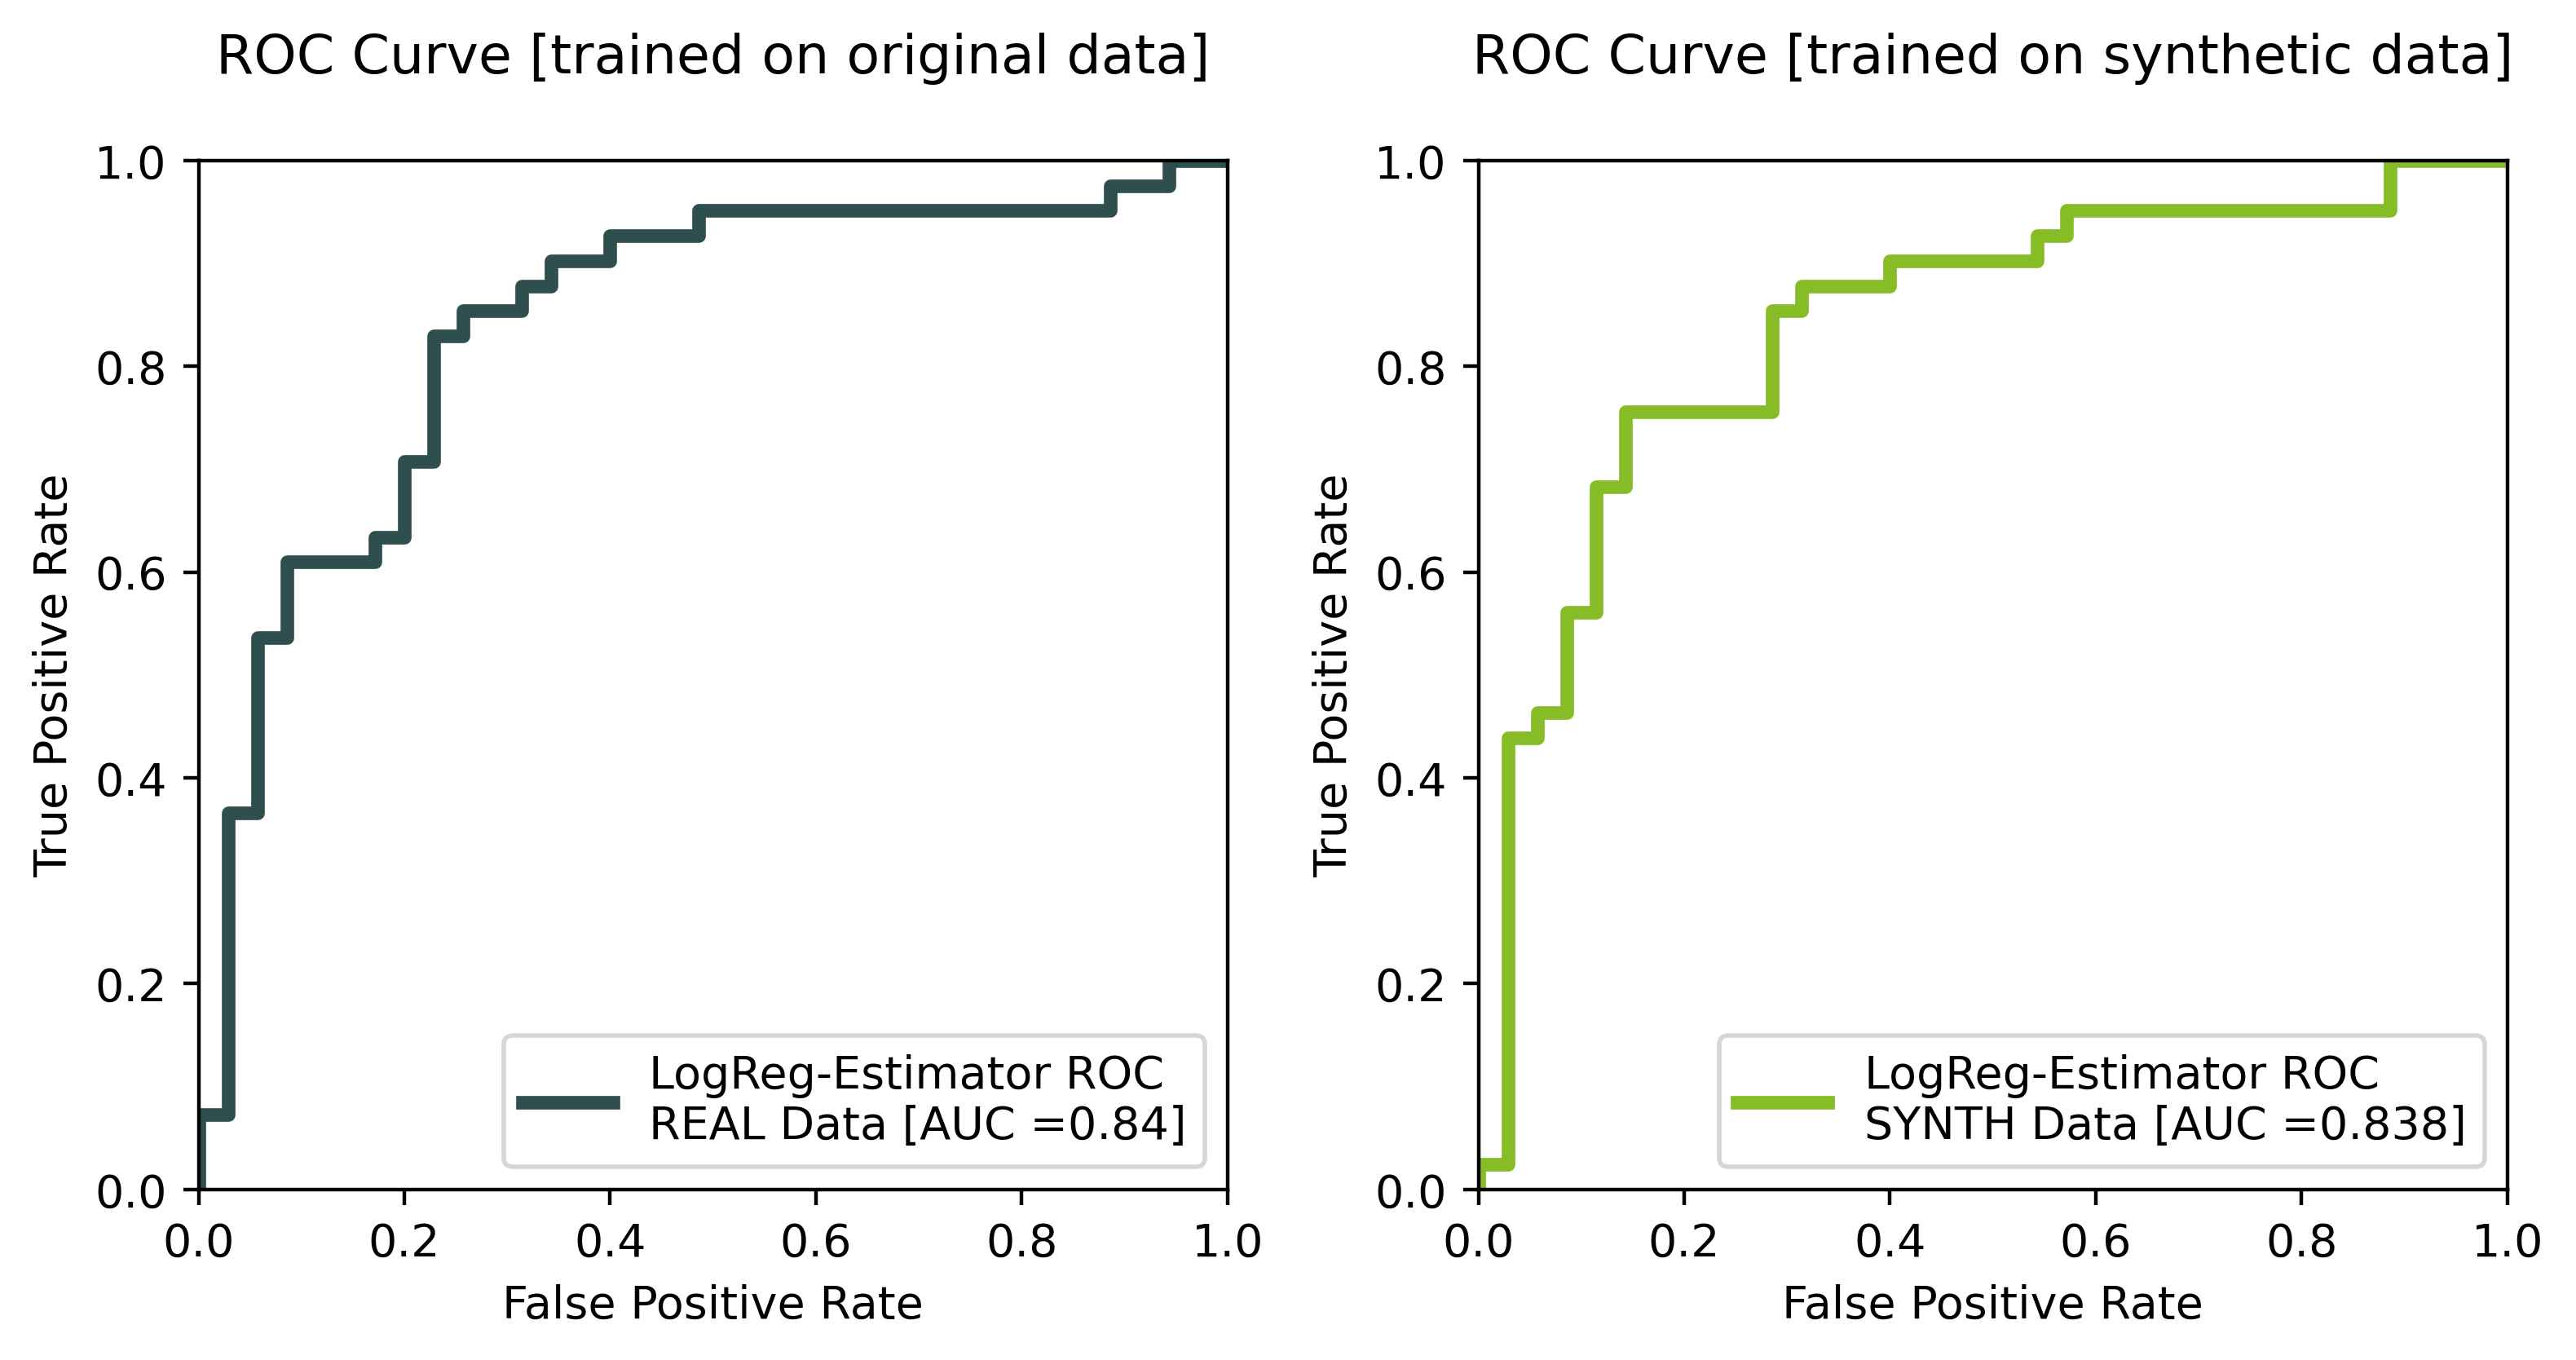

Saved synthetic data at : synth_data/synth_train_dpwgan_borealis_heartdisease.csv


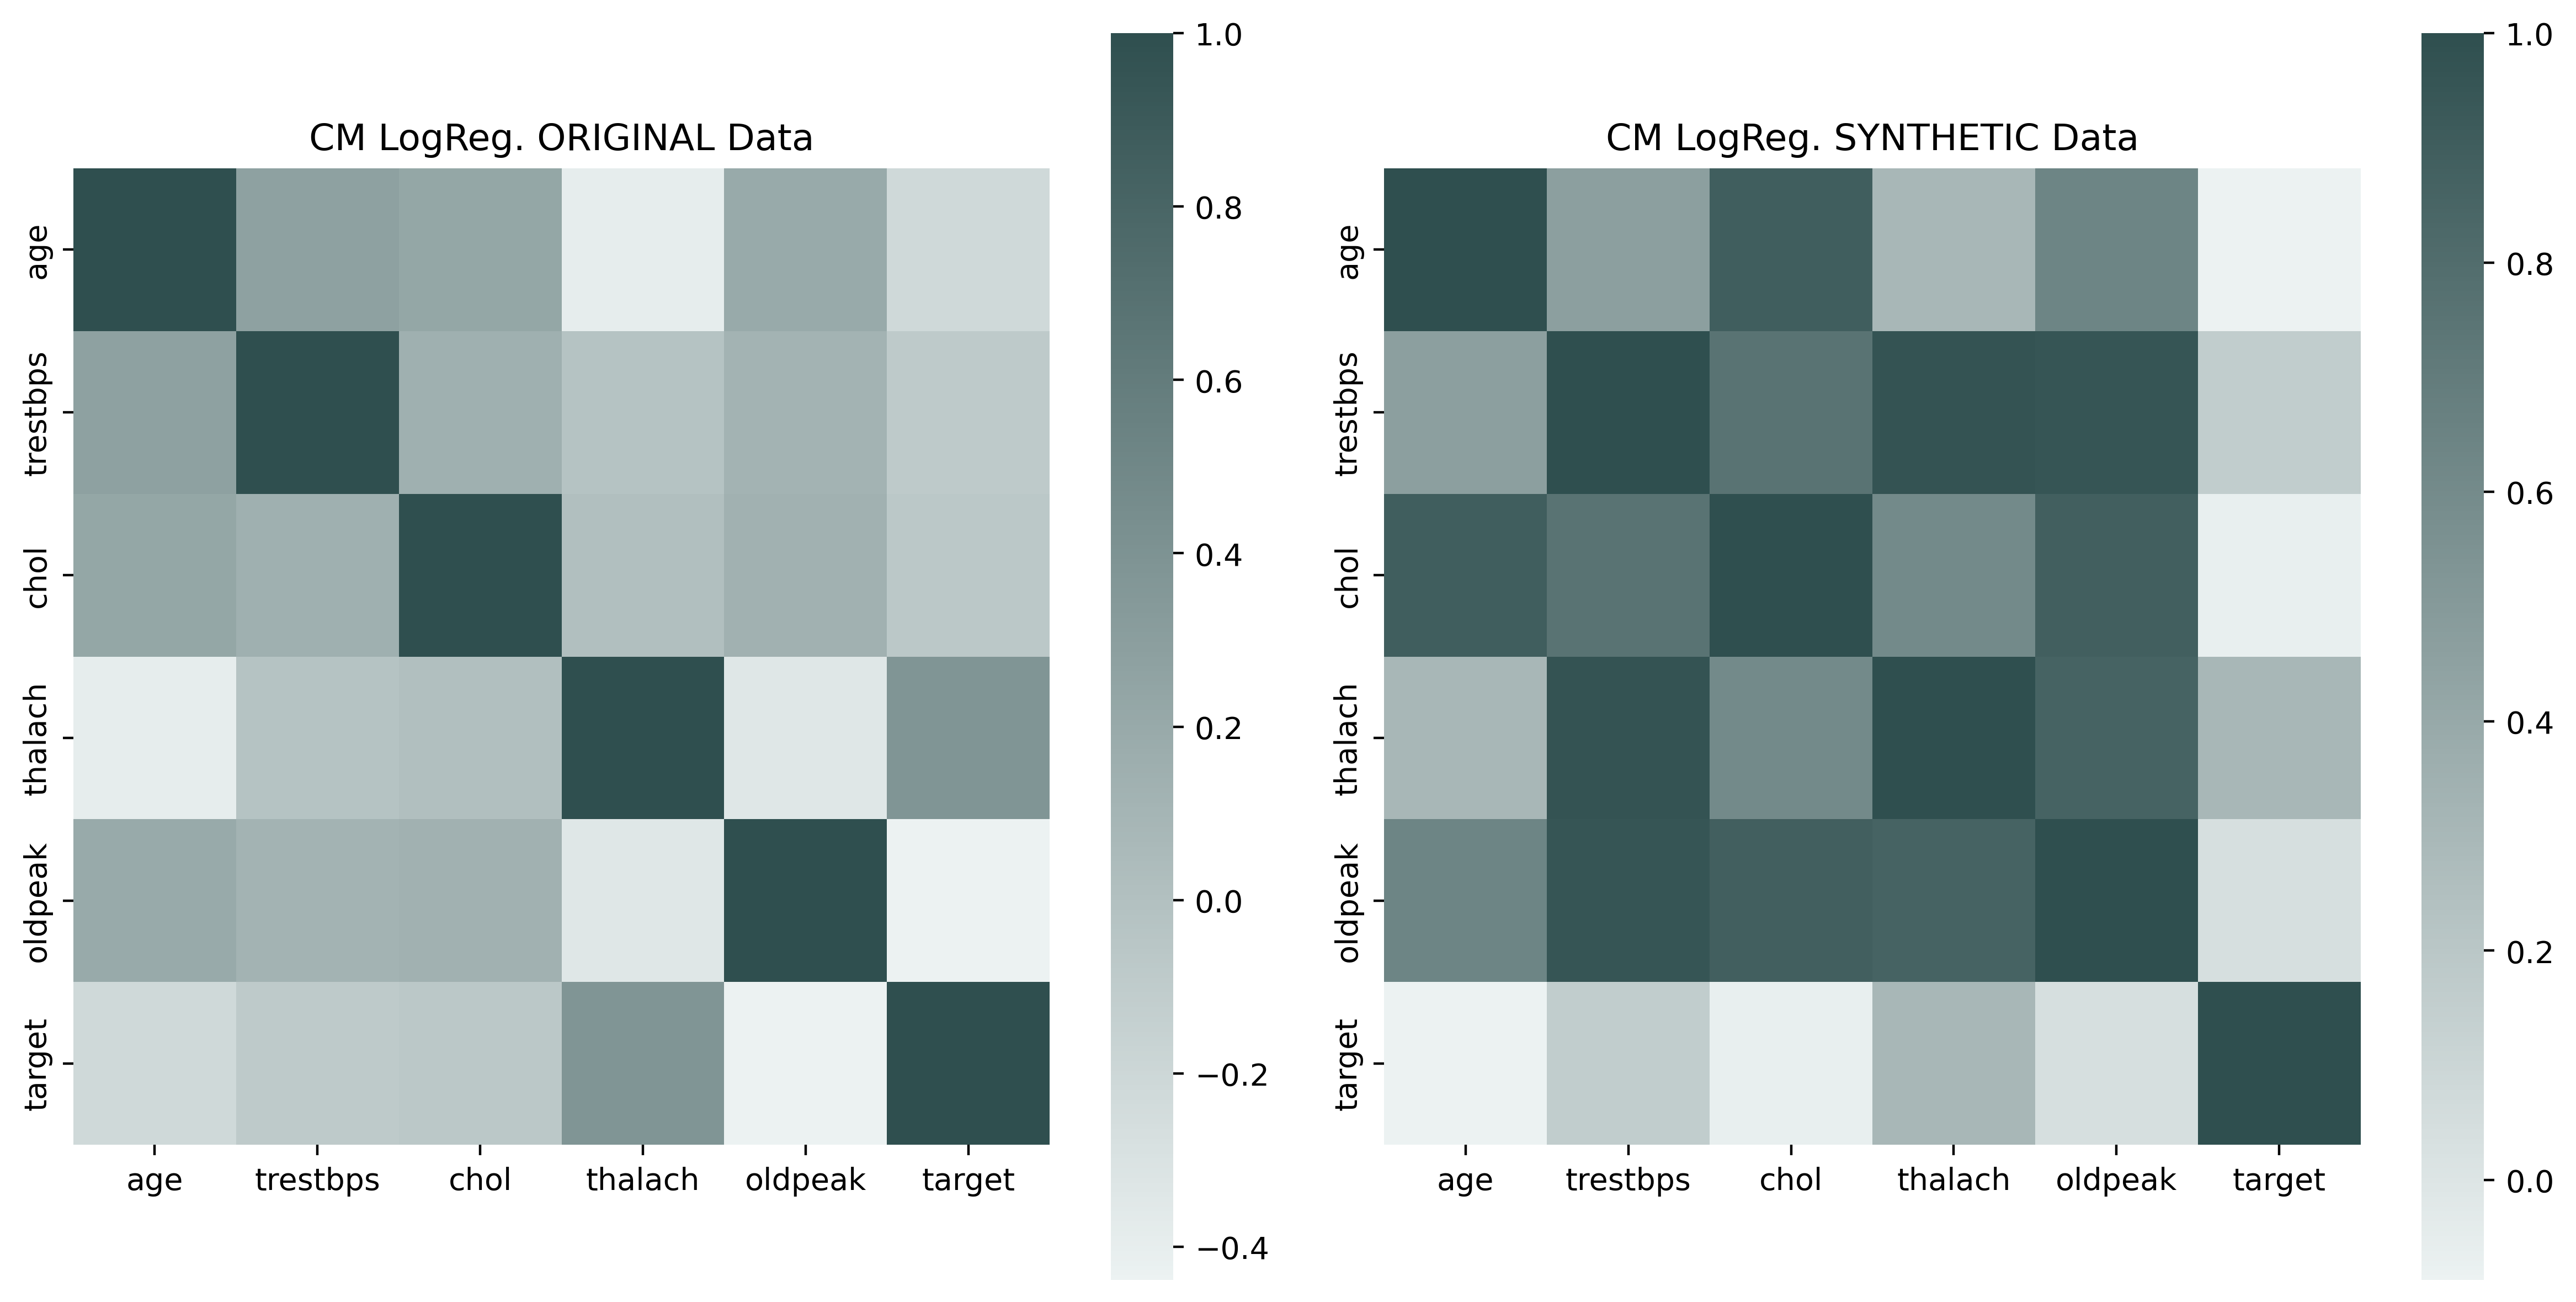

,attribute_name,orig_mean,orig_var,orig_min,orig_max,synth_mean,synth_var,synth_min,synth_max
0,age,0.5317,0.037489,0.000000,1.000000,0.2131,0.036015,0.000851,1.000851
1,trestbps,0.3410,0.025819,0.000000,0.924528,0.2511,0.037398,0.000548,0.925077
2,chol,0.2743,0.014958,0.011416,1.000000,0.2110,0.032125,0.000240,0.988824
3,thalach,0.6009,0.029779,0.129771,1.000000,0.2734,0.041032,0.000282,0.870511
4,oldpeak,0.1658,0.031825,0.000000,0.903226,0.2152,0.030869,0.000213,0.903439
5,target,0.5463,0.248957,0.000000,1.000000,0.5771,0.245137,0.000000,1.000000


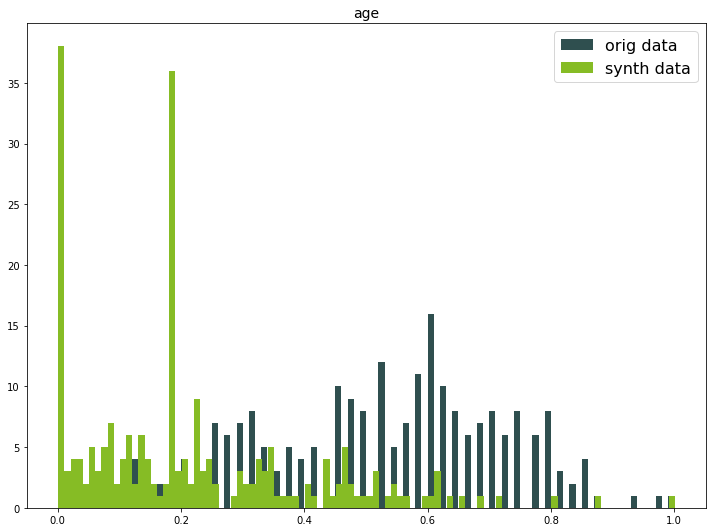

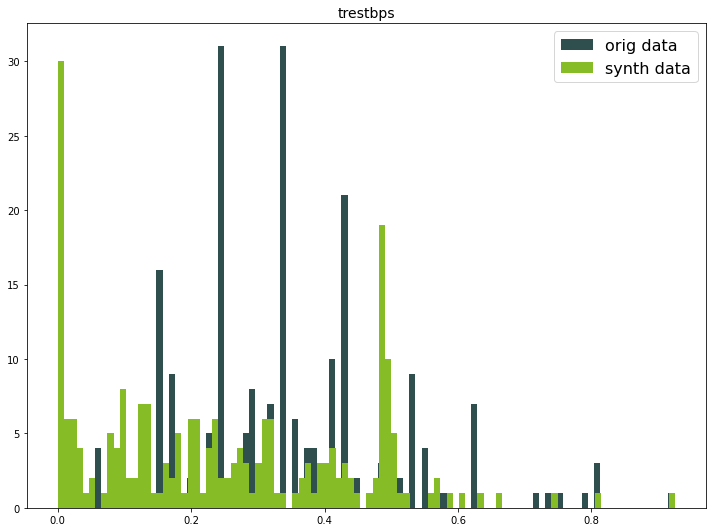

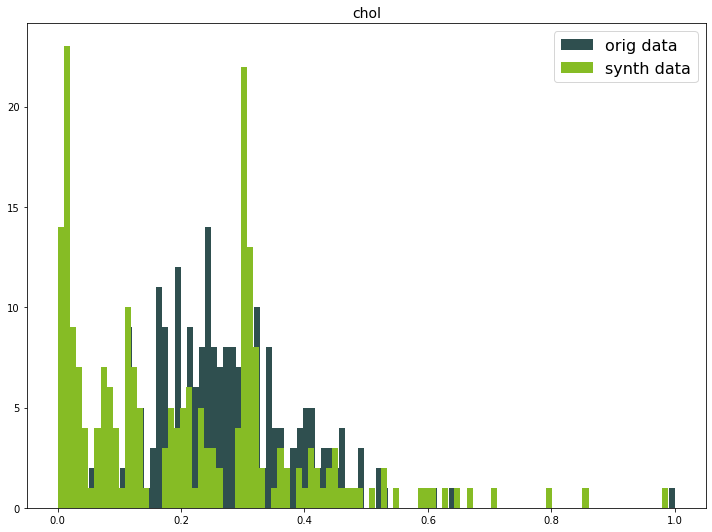

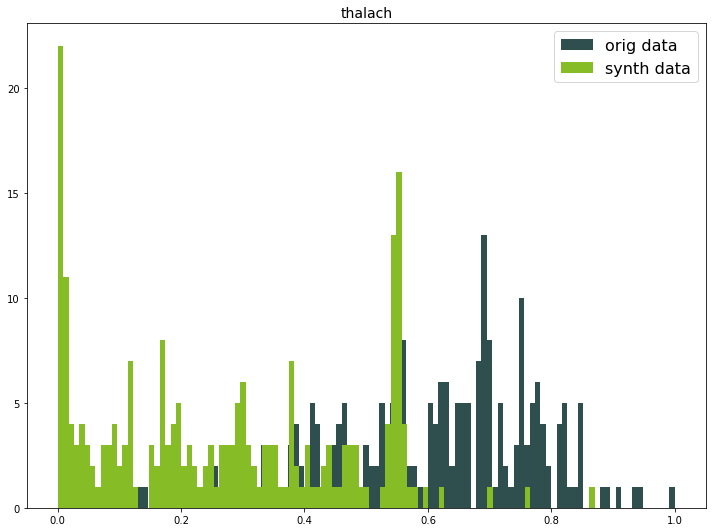

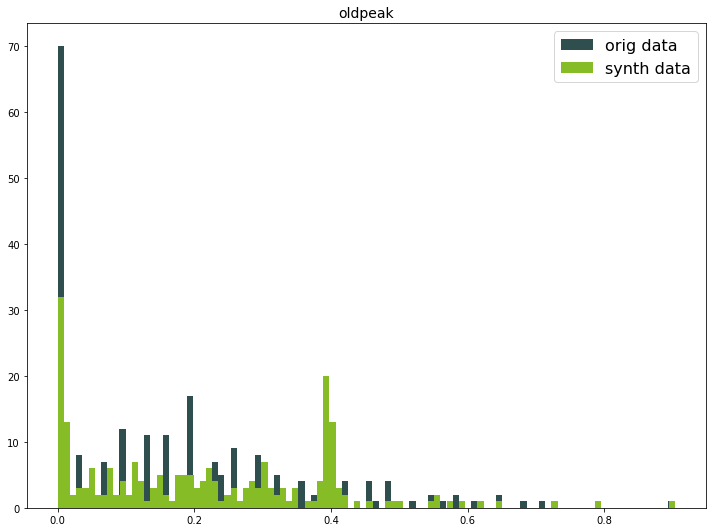

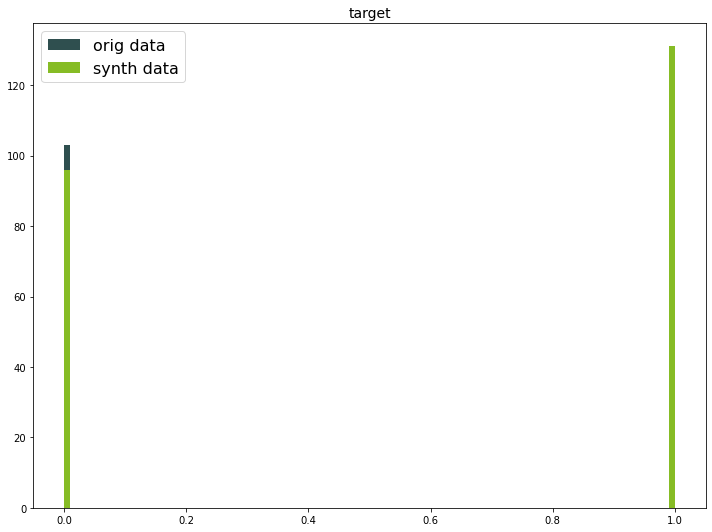

In [383]:
# RUN SETUP for banknote dataset
dpsdg_main(Args_setup_heart())